In [ ]:
import os
import numpy as np


def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):    
        if (image_name.split('.')[1] == 'npy'):
            
            image = np.load(img_dir+image_name)
                      
            images.append(image)
    images = np.array(images)
    
    return(images)




def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)
  
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
                       
            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            # Casting images and masks to float32
            X = X.astype(np.float32)
            Y = Y.astype(np.float32)
            
            yield (X,Y)    

            batch_start += batch_size   
            batch_end += batch_size


In [2]:
from matplotlib import pyplot as plt
import random

train_img_dir = "Downloads/archive_2/input/output_data/train/images/"
train_mask_dir = "Downloads/archive_2/input/output_data/train/masks/"
train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

In [3]:
#verfying
img, msk = train_img_datagen.__next__()


In [4]:
img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

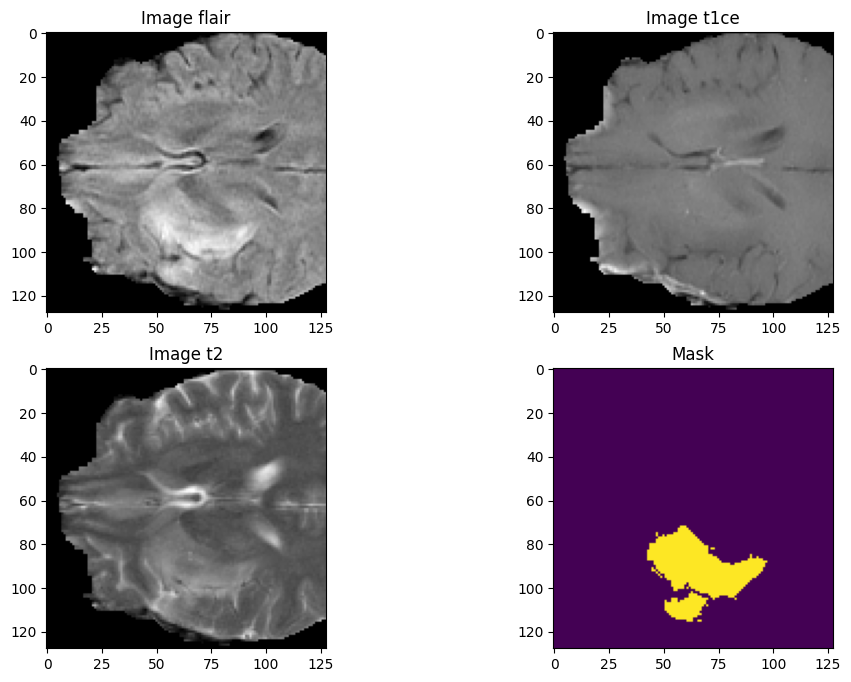

In [17]:
n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [18]:
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Multiply, Add, UpSampling3D, Activation, Lambda
from keras import backend as K
import tensorflow as tf

kernel_initializer = 'he_uniform'

# Helper function to repeat elements
def repeat_elem(tensor, rep):
    return Lambda(lambda x: K.repeat_elements(x, rep, axis=4))(tensor)

# 3D Gating Signal
def gating_signal_3d(input, out_size, batch_norm=False):
    x = Conv3D(out_size, (1, 1, 1), padding='same')(input)
    if batch_norm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

# 3D Attention Block
def attention_block_3d(x, gating, inter_shape):
    shape_x = K.int_shape(x)  # (batch, D, H, W, C)
    shape_g = K.int_shape(gating)  # (batch, D, H, W, C)

    # theta_x with stride 2x2x2
    theta_x = Conv3D(inter_shape, (2, 2, 2), strides=(2, 2, 2), padding='same')(x)
    shape_theta_x = K.int_shape(theta_x)
    
    # phi_g with 1x1x1 conv
    phi_g = Conv3D(inter_shape, (1, 1, 1), padding='same')(gating)
    
    # Upsample phi_g to match theta_x dimensions
    upsample_g = Conv3DTranspose(
        inter_shape, (3, 3, 3),
        strides=(shape_theta_x[1]//shape_g[1], shape_theta_x[2]//shape_g[2], shape_theta_x[3]//shape_g[3]),
        padding='same')(phi_g)

    # Combine signals
    concat_xg = Add()([upsample_g, theta_x])
    act_xg = Activation('relu')(concat_xg)
    
    # Attention weights
    psi = Conv3D(1, (1, 1, 1), padding='same')(act_xg)
    sigmoid_xg = Activation('sigmoid')(psi)
    
    # Upsample attention weights
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = UpSampling3D(
        size=(shape_x[1]//shape_sigmoid[1], 
              shape_x[2]//shape_sigmoid[2],
              shape_x[3]//shape_sigmoid[3]))(sigmoid_xg)
    
    # Repeat attention across channels
    upsample_psi = repeat_elem(upsample_psi, shape_x[4])
    
    # Apply attention
    y = Multiply()([upsample_psi, x])
    
    # Final convolution
    result = Conv3D(shape_x[4], (1, 1, 1), padding='same')(y)
   # result_bn = BatchNormalization()(result)
    return result



In [ ]:
from keras import layers

def res_conv_block_3d(x, filter_size, size, dropout):
  
    # First 3D convolutional layer
    conv = layers.Conv3D(size, (filter_size, filter_size, filter_size), padding='same', kernel_initializer='he_uniform')(x)
    conv = layers.BatchNormalization(axis=-1)(conv)  # axis=4 for channels-last format in 3D
    conv = layers.Activation('relu')(conv)
    
    # Second 3D convolutional layer
    conv = layers.Conv3D(size, (filter_size, filter_size, filter_size), padding='same', kernel_initializer='he_uniform')(conv)
    conv = layers.BatchNormalization(axis=-1)(conv)  # axis=4 for channels-last format in 3D
    # conv = layers.Activation('relu')(conv)  # Activation before addition with shortcut
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    # Shortcut connection
    shortcut = layers.Conv3D(size, kernel_size=(1, 1, 1), padding='same', kernel_initializer='he_uniform')(x)
    shortcut = layers.BatchNormalization(axis=-1)(shortcut)  # axis=4 for channels-last format in 3D

    # Adding shortcut and main path
    res_path = layers.add([shortcut, conv])
    res_path = layers.Activation('relu')(res_path)  # Activation after addition with shortcut (Original residual block)
    return res_path


In [ ]:
# 3D Attention ResU-Net Model
def attention_ResUNet_3d(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    x = inputs
    FILTER_NUM = 16 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter

    # Contracting Path
    c1 = res_conv_block_3d(inputs, FILTER_SIZE, FILTER_NUM, 0.1)
    p1 = layers.MaxPooling3D((2,2,2))(c1)
    
    c2 = res_conv_block_3d(p1, FILTER_SIZE, 2*FILTER_NUM, 0.1)
    p2 = layers.MaxPooling3D((2,2,2))(c2)
    # DownRes 3
    c3 = res_conv_block_3d(p2, FILTER_SIZE, 4*FILTER_NUM,  0.2)
    p3 = layers.MaxPooling3D((2,2,2))(c3)
    # DownRes 4
    c4 = res_conv_block_3d(p3, FILTER_SIZE, 8*FILTER_NUM, 0.2)
    p4 = layers.MaxPooling3D((2,2,2))(c4)
    # DownRes 5, convolution only
    c5 = res_conv_block_3d(p4, FILTER_SIZE, 16*FILTER_NUM, 0.3)

    
    
    # Expansive Path with Attention
    g6 = gating_signal_3d(c5, 128, batch_norm=False)
    att6 = attention_block_3d(c4, g6, 128)
    u6 = Conv3DTranspose(128, (2,2,2), strides=(2,2,2), padding='same')(c5)
    u6 = concatenate([u6, att6])
    c6 = Conv3D(128, (3,3,3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3,3,3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)
    
    g7 = gating_signal_3d(c6, 64, batch_norm=False)
    att7 = attention_block_3d(c3, g7, 64) 
    u7 = Conv3DTranspose(64, (2,2,2), strides=(2,2,2), padding='same')(c6)
    u7 = concatenate([u7, att7])
    c7 = Conv3D(64, (3,3,3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3,3,3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)
     
    g8 = gating_signal_3d(c7, 32, batch_norm=False)
    att8 = attention_block_3d(c2, g8, 32)
    u8 = Conv3DTranspose(32, (2,2,2), strides=(2,2,2), padding='same')(c7)
    u8 = concatenate([u8, att8])
    c8 = Conv3D(32, (3,3,3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3,3,3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)
     
    g9 = gating_signal_3d(c8, 16, batch_norm=False)
    att9 = attention_block_3d(c1, g9, 16)
    u9 = Conv3DTranspose(16, (2,2,2), strides=(2,2,2), padding='same')(c8)
    u9 = concatenate([u9, att9])
    c9 = Conv3D(16, (3,3,3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3,3,3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)
     
    outputs = Conv3D(num_classes, (1,1,1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

model = attention_ResUNet_3d(128, 128, 64, 3, 4)
model.summary()

print(model.input_shape)
print(model.output_shape)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 6  0           []                               
                                4, 3)]                                                            
                                                                                                  
 conv3d (Conv3D)                (None, 128, 128, 64  1312        ['input_1[0][0]']                
                                , 16)                                                             
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  64         ['conv3d[0][0]']                 
 alization)                     , 16)                                                         

In [21]:
import os
import numpy as np
import tensorflow as tf
import keras
from matplotlib import pyplot as plt
import glob
import random

In [22]:
train_img_dir = "Downloads/archive_2/input/output_data/train/images/"
train_mask_dir = "Downloads/archive_2/input/output_data/train/masks/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))
img_num = random.randint(0,num_images-1)
test_img = np.load(train_img_dir+img_list[img_num])
test_mask = np.load(train_mask_dir+msk_list[img_num])
test_mask = np.argmax(test_mask, axis=3)


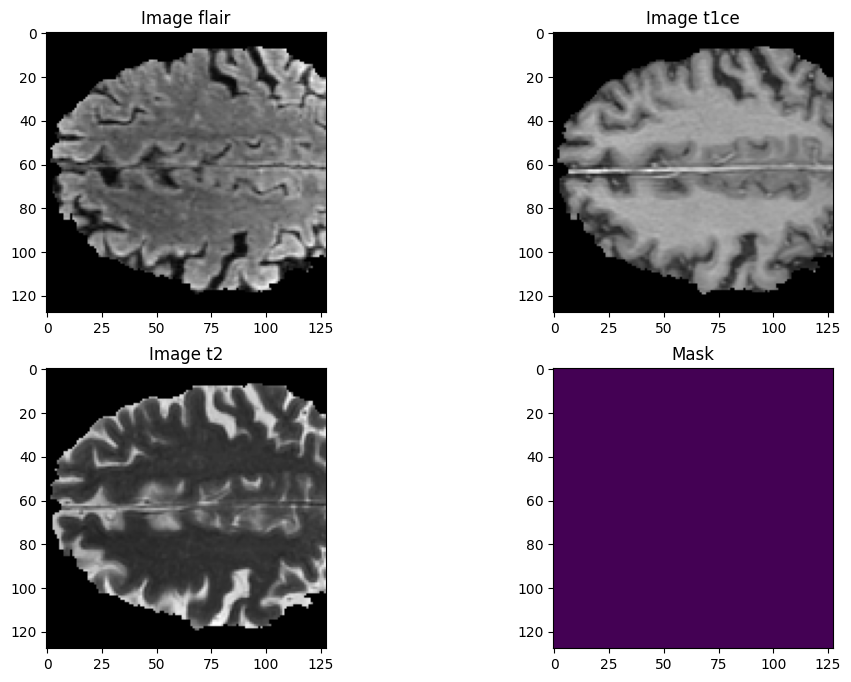

In [64]:
n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [ ]:
#Defining the image generators for training and validation

train_img_dir = "Downloads/archive_2/input/output_data/train/images/"
train_mask_dir = "Downloads/archive_2/input/output_data/train/masks/"

val_img_dir = "Downloads/archive_2/input/output_data/val/images/"
val_mask_dir = "Downloads/archive_2/input/output_data/val/masks/"

train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list=os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

In [66]:
batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)


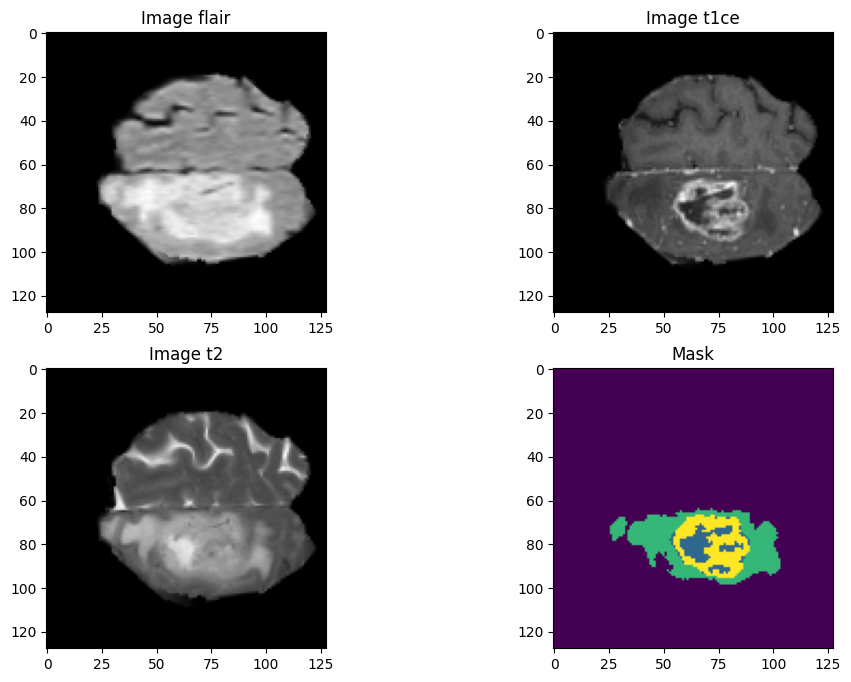

In [70]:
img, msk = train_img_datagen.__next__()

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [ ]:
def dice_coef(y_true, y_pred, smooth=1.0):
    """
    Dice coefficient for multi-class segmentation.
    y_true: Ground truth (batch_size, height, width, num_classes)
    y_pred: Predicted probabilities (batch_size, height, width, num_classes)
    smooth: Smoothing factor to avoid division by zero.
    """
    class_num = 4  # Fixed number of classes
    total_loss = 0.0

    for i in range(class_num):
        y_true_f = K.flatten(y_true[..., i])  # Flattening the ground truth for class i
        y_pred_f = K.flatten(y_pred[..., i])  # Flattening the predictions for class i
        intersection = K.sum(y_true_f * y_pred_f)  # Compute the intersection
        loss = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
        total_loss += loss

    return total_loss / class_num  # Return the average Dice coefficient

# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    
# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [72]:
#wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
#
#dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3])) 
#focal_loss = sm.losses.CategoricalFocalLoss()
#total_loss = dice_loss + (1 * focal_loss)

#import tensorflow as tf
#from tensorflow.keras import backend as K

#def focal_loss(gamma=2.0, alpha=0.25):
#    def focal_loss_fn(y_true, y_pred):
        # Clip predictions to prevent log(0) or log(1)
#        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
        
        # Calculate cross-entropy
#        cross_entropy = -y_true * K.log(y_pred)
        
        # Calculate the focal loss
#        loss = alpha * K.pow(1.0 - y_pred, gamma) * cross_entropy
        
        # Sum over classes and average over batch
#        return K.sum(loss, axis=-1)
    
#   return focal_loss_fn

metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity]

LR = 0.0001
optim = keras.optimizers.Adam(LR)

In [74]:
#Fit the model 
#import segmentation_models_3D as sm
steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "Downloads/archive_2/model_segmentation/brats_2021_200epoch_residual.hdf5",  # Save path
    monitor="val_dice_coef",  # Monitor validation dice coefficient
    save_best_only=True,  # Save only the best model
    save_weights_only=False,  # Save the full model (not just weights)
    mode="max",  # Maximize validation accuracy
    verbose=1  # Print when the model is saved
)


model = attention_ResUNet_3d(IMG_HEIGHT=128, 
                          IMG_WIDTH=128, 
                          IMG_DEPTH=64, 
                          IMG_CHANNELS=3, 
                          num_classes=4)

model.compile(optimizer = optim, loss='categorical_crossentropy', metrics=metrics)


In [75]:
history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=200,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          callbacks=[checkpoint_cb],
          )



Epoch 1/200
469/469 [==============================] - ETA: 0s - loss: 0.1904 - accuracy: 0.9331 - mean_io_u: 0.3939 - dice_coef: 0.3510 - precision: 0.9495 - sensitivity: 0.8927 - specificity: 0.9937
Epoch 1: val_dice_coef improved from -inf to 0.38416, saving model to Downloads/archive_2/model_segmentation\brats_2021_200epoch_residual.hdf5
469/469 [==============================] - 454s 923ms/step - loss: 0.1904 - accuracy: 0.9331 - mean_io_u: 0.3939 - dice_coef: 0.3510 - precision: 0.9495 - sensitivity: 0.8927 - specificity: 0.9937 - val_loss: 0.1462 - val_accuracy: 0.9497 - val_mean_io_u: 0.3750 - val_dice_coef: 0.3842 - val_precision: 0.9747 - val_sensitivity: 0.9311 - val_specificity: 0.9922
Epoch 2/200
469/469 [==============================] - ETA: 0s - loss: 0.0855 - accuracy: 0.9699 - mean_io_u: 0.4277 - dice_coef: 0.4318 - precision: 0.9823 - sensitivity: 0.9608 - specificity: 0.9943
Epoch 2: val_dice_coef improved from 0.38416 to 0.42699, saving model to Downloads/archive_2

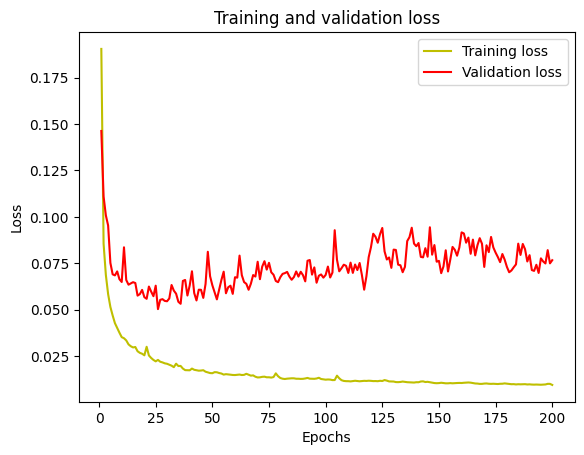

In [77]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

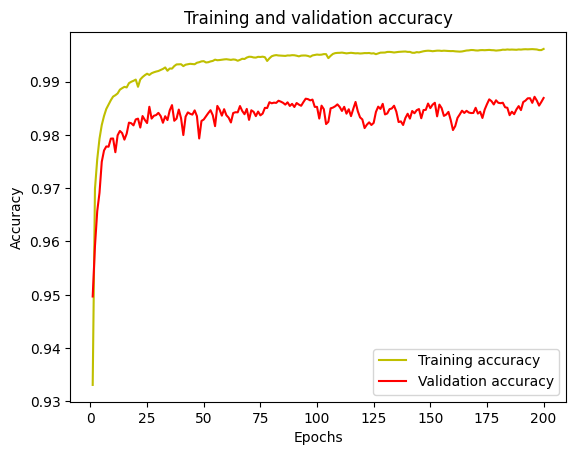

In [78]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

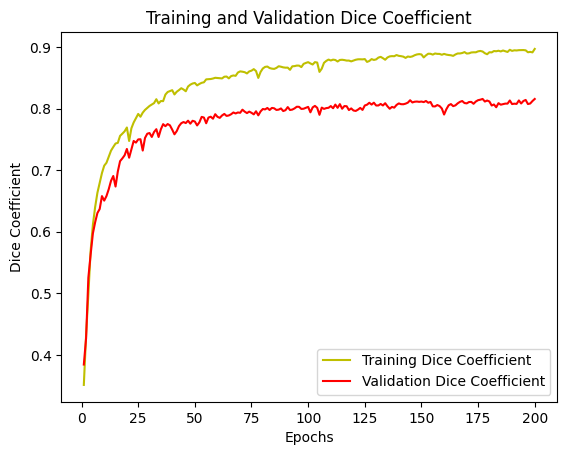

In [79]:
dice = history.history['dice_coef']
val_dice = history.history['val_dice_coef']

epochs = range(1, len(dice) + 1)
plt.plot(epochs, dice, 'y', label='Training Dice Coefficient')
plt.plot(epochs, val_dice, 'r', label='Validation Dice Coefficient')
plt.title('Training and Validation Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()


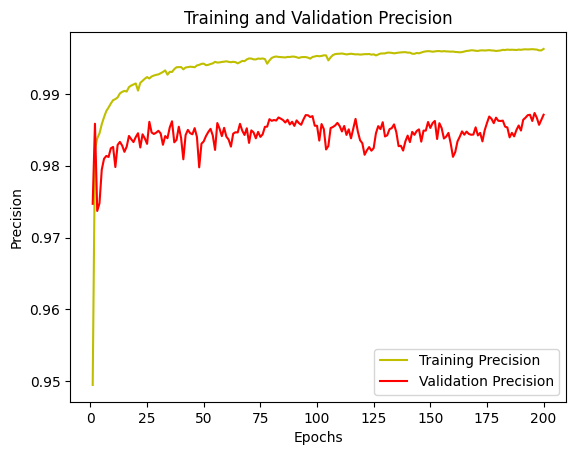

In [80]:
precision = history.history['precision']
val_precision = history.history['val_precision']
epochs = range(1, len(precision) + 1)
plt.plot(epochs, precision, 'y', label='Training Precision')
plt.plot(epochs, val_precision, 'r', label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()



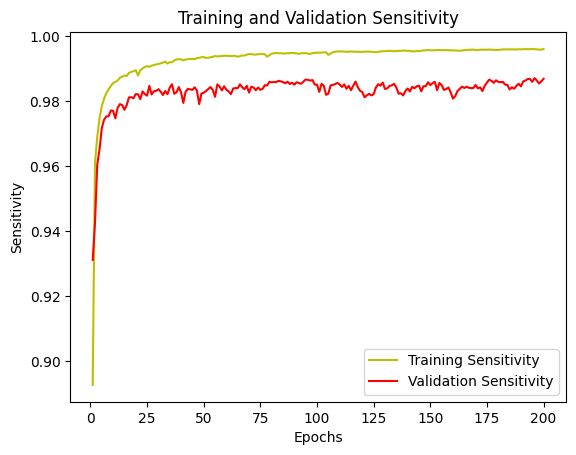

In [81]:
sensitivity = history.history['sensitivity']
val_sensitivity = history.history['val_sensitivity']
epochs = range(1, len(sensitivity) + 1)
plt.plot(epochs, sensitivity, 'y', label='Training Sensitivity')
plt.plot(epochs, val_sensitivity, 'r', label='Validation Sensitivity')
plt.title('Training and Validation Sensitivity')
plt.xlabel('Epochs')
plt.ylabel('Sensitivity')
plt.legend()
plt.show()




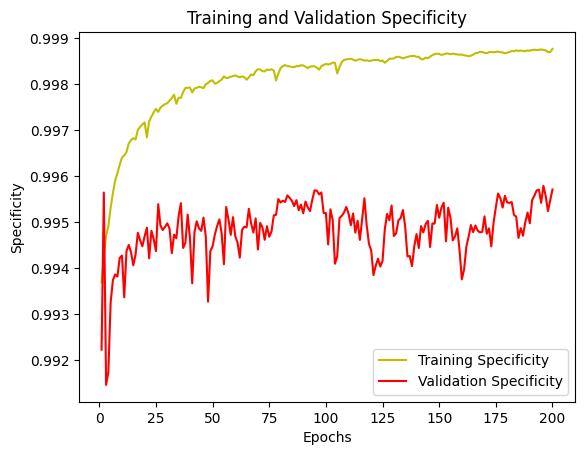

In [82]:
specificity = history.history['specificity']
val_specificity = history.history['val_specificity']
epochs = range(1, len(specificity) + 1)
plt.plot(epochs, specificity, 'y', label='Training Specificity')
plt.plot(epochs, val_specificity, 'r', label='Validation Specificity')
plt.title('Training and Validation Specificity')
plt.xlabel('Epochs')
plt.ylabel('Specificity')
plt.legend()
plt.show()





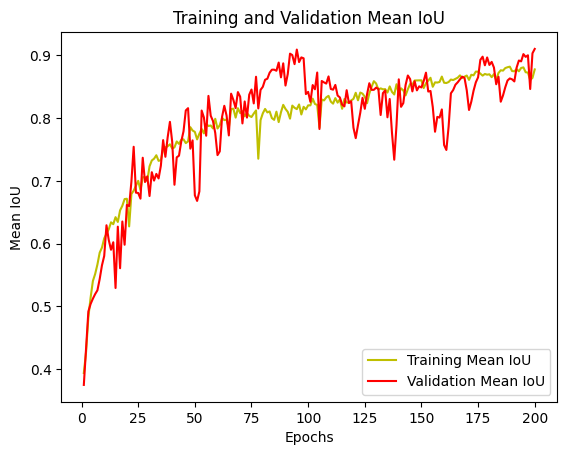

In [83]:
mean_iou = history.history['mean_io_u']
val_mean_iou = history.history['val_mean_io_u']
epochs = range(1, len(mean_iou) + 1)
plt.plot(epochs, mean_iou, 'y', label='Training Mean IoU')
plt.plot(epochs, val_mean_iou, 'r', label='Validation Mean IoU')
plt.title('Training and Validation Mean IoU')
plt.xlabel('Epochs')
plt.ylabel('Mean IoU')
plt.legend()
plt.show()






In [30]:
import os
print(os.getcwd())


C:\Users\User


In [76]:
#model.save('Downloads/archive_2/model_segmentation/brats_2021_200epoch_residual2.hdf5')


In [92]:
from keras.models import load_model
my_model = load_model('Downloads/archive_2/model_segmentation/brats_2021_200epoch_residual.hdf5', compile = False)

In [93]:
from keras import backend as K


In [94]:
#Prediction on a few test images, one at a time

img_num = 221

test_img = np.load("Downloads/archive_2/input/output_data/val/images/image_"+str(img_num)+".npy")

test_mask = np.load("Downloads/archive_2/input/output_data/val/masks/mask_"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = my_model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]

1/1 [==============================] - 0s 479ms/step


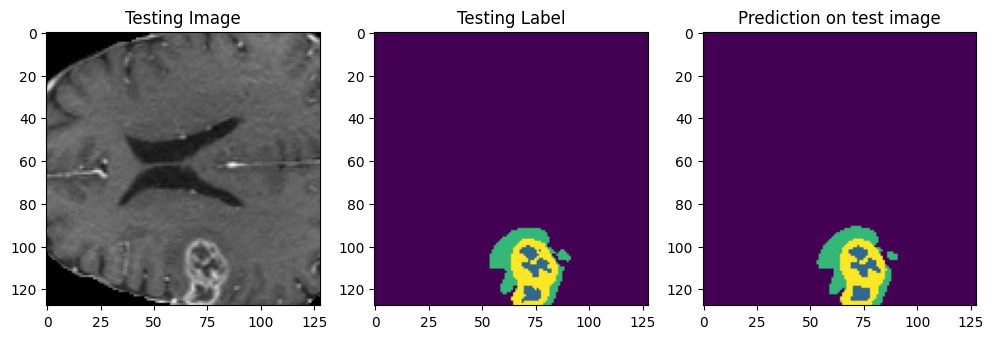

In [95]:
#Plot individual slices from test predictions for verification
from matplotlib import pyplot as plt
import random

#n_slice=random.randint(0, test_prediction_argmax.shape[2])
n_slice = 12
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()